<a href="https://colab.research.google.com/github/BSteiner1/MultiDeepQLearn/blob/main/MultiDeepQLearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import random
import matplotlib.pyplot as plt

In [2]:
# Define the demand function parameters
# Vertical Differentiation
a1 = 2
a2 = 2
# Outside good
a0 = 0


In [50]:
# Marginal cost
c = 1
# Number of prices to choose from
num_prices = 40
price_options = [round(0.05*i, 2) for i in range(1, num_prices+1)]

In [4]:
# Price sensitivity
mu = 0.1

In [5]:
# Epsilon-Greedy Strategy
epsilon = 0.1

In [6]:
# Function to calculate the logit demand for a given product
def logit_demand(price, other_price):
    q = np.exp((2 - price)/mu) / (np.exp((2 - other_price)/mu)) # + np.exp(0/mu))
    return q

In [7]:
# Build the network
net = nn.Sequential(
    nn.Linear(2, 64),
    nn.ReLU(),
    nn.Linear(64, 8)
)

In [8]:
def epsilon_greedy_action_selection(net, state, epsilon):
    if np.random.rand() < epsilon:
        #print("GREEDY")
        # Exploration
        return random.choice([i for i in range(num_prices)])

    else:
        # Exploitation
        #print("EXPLOIT")
        with torch.no_grad():
            q_values = net(state)
            #print(q_values.detach().numpy())
            #print(q_values.argmax().item())
            return q_values.argmax().item()

In [9]:
# Function to simulate the environment based on chosen actions and calculate rewards
def simulate_environment(prices):
    price1, price2 = prices[0], prices[1]

    # Calculate the demand for each business
    demand1 = logit_demand(price1, price2)
    demand2 = logit_demand(price2, price1)

    # Calculate the revenue and profit for each product
    revenue1 = price1 * demand1
    revenue2 = price2 * demand2

    # Assuming the agents have 0 marginal cost
    profit1 = revenue1 - demand1 * c
    profit2 = revenue2 - demand2 * c

    return [profit1, profit2]

In [98]:
num_episodes = 20000
learning_rate = 0.0001
discount_factor = 0.99
epsilon = 0.1
max_steps_per_episode = 20

In [99]:
def train_q_learning(num_episodes, learning_rate, discount_factor, epsilon, max_steps_per_episode):

    start_time = time.time()

    state_size = 4  # Dimension of the state space (current prices of both businesses)
    action_size = 40  # Number of possible prices for each business
    hidden_size = 256 # Size of the hidden layer in the Q-value model

    # Create the Q-value models for each agent
    q_value_model_agent1 = nn.Sequential(
        nn.Linear(state_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, action_size)
    )
    q_value_model_agent2 = nn.Sequential(
        nn.Linear(state_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, action_size)
    )

    optimizer_agent1 = optim.Adam(q_value_model_agent1.parameters(), lr=learning_rate)
    optimizer_agent2 = optim.Adam(q_value_model_agent2.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    profit1 = []

    for episode in range(num_episodes):
      if episode%250 == 0:
        print(episode)
      # Initialize with random prices for both businesses
      price_business1 = random.choice(price_options)
      price_business2 = random.choice(price_options)

      state = torch.tensor([price_business1, price_business2, 0, 0], dtype=torch.float32)

      episode_actions = []
      episode_profit = 0
      step = 0
      while step < max_steps_per_episode:
        #print("Step", step)
        # Agent 1 chooses action based on the current state and epsilon-greedy strategy
        action_agent1 = epsilon_greedy_action_selection(q_value_model_agent1, state, epsilon)
        episode_actions.append(action_agent1)

        # Agent 2 chooses action based on the current state and epsilon-greedy strategy
        action_agent2 = epsilon_greedy_action_selection(q_value_model_agent2, state, epsilon)

        # Combine the chosen actions to form the joint action (prices for both agents)
        joint_action = [price_options[action_agent1], price_options[action_agent2]]
        #print(joint_action)

        # Simulate the environment based on the joint action and calculate rewards
        rewards = simulate_environment(joint_action)

        episode_profit += rewards[0]

        # Create the next state tensor from the new prices
        last_state = state.tolist()[:2]
        next_state = torch.tensor(joint_action + last_state, dtype=torch.float32)
        #print(next_state)

        # Calculate the Q-value target for the current state-action pair
        with torch.no_grad():
            q_value_target_agent1 = torch.tensor(rewards[0], dtype=torch.float32) + discount_factor * torch.max(q_value_model_agent1(next_state))
            q_value_target_agent2 = torch.tensor(rewards[1], dtype=torch.float32) + discount_factor * torch.max(q_value_model_agent2(next_state))

        # Calculate the Q-value prediction for the current state-action pair
        q_value_prediction_agent1 = q_value_model_agent1(state)[action_agent1]
        q_value_prediction_agent2 = q_value_model_agent2(state)[action_agent2]

        # Compute the loss and perform backpropagation for each agent
        optimizer_agent1.zero_grad()
        loss_agent1 = criterion(q_value_prediction_agent1, q_value_target_agent1)
        loss_agent1.backward()
        optimizer_agent1.step()

        optimizer_agent2.zero_grad()
        loss_agent2 = criterion(q_value_prediction_agent2, q_value_target_agent2)
        loss_agent2.backward()
        optimizer_agent2.step()

        # Update the state for the next iteration
        state = next_state
        step += 1

        #print("Q Agent 1:", q_value_model_agent1(state).detach().numpy())

      profit1.append(episode_profit)
      #if episode%50 == 0:
        #print(episode_actions)

    end_time = time.time()
    elapsed_time = end_time - start_time
    time_per_episode = elapsed_time/num_episodes
    print("Total Number of Episodes:", num_episodes)
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print(f"Average Time per Episode: {time_per_episode:.3f} seconds")

    #print(profit1)

    return q_value_model_agent1, q_value_model_agent2, profit1

In [100]:
trained_model_agent1, trained_model_agent2, profit1 = train_q_learning(num_episodes, learning_rate, discount_factor, epsilon, max_steps_per_episode)

0
250
500


KeyboardInterrupt: ignored

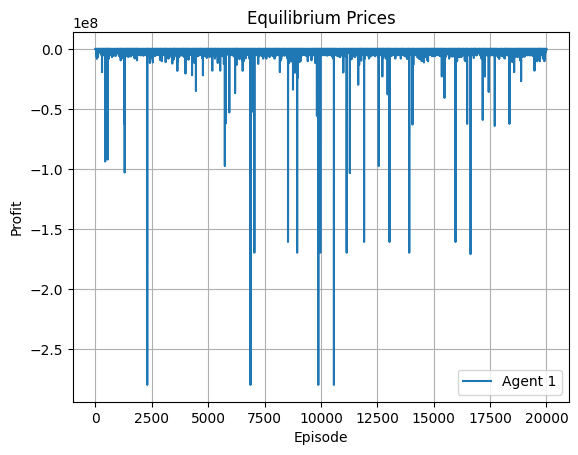

In [83]:
episodes = range(len(profit1))  # Assuming both lists have the same length (number of episodes)

plt.plot(episodes, profit1, label='Agent 1')

plt.xlabel('Episode')
plt.ylabel('Profit')
plt.title('Equilibrium Prices')
plt.legend()
plt.grid(True)
plt.show()

In [84]:
profit1[-120:-100]

[-438.89320060455617,
 359.96647974981596,
 19.311250568776828,
 -5120067.790413812,
 415.0506118094426,
 -1685210.8721405186,
 157.54839680378865,
 149.98211305303775,
 -54144.40452210419,
 431.45668641090316,
 -546914.579641243,
 307.02617297044986,
 423.18537276708565,
 -339455.7597439654,
 -5129.965798729565,
 -5119896.0225467,
 -8062482.230511018,
 157.29901649183282,
 158.53766004136466,
 126.75375155438955]

In [85]:
def play_agents(agent1_model, agent2_model, max_iterations):

    prices1 = []
    prices2 = []
    profit1 = 0
    profit2 = 0

    # Start with random prices for both businesses
    price_agent1 = random.choice(price_options)
    price_agent2 = random.choice(price_options)

    start_action = [price_agent1, price_agent2]

    prices1.append(price_agent1)
    prices2.append(price_agent2)

    p1 = simulate_environment(start_action)[0]
    p2 = simulate_environment(start_action)[1]

    profit1 += p1
    profit2 += p2

    state = torch.tensor([price_agent1, price_agent2, 0, 0], dtype=torch.float32)

    for _ in range(max_iterations):
        # Get the Q-values for both agents from their models
        q_values_agent1 = agent1_model(state)
        q_values_agent2 = agent2_model(state)

        # Choose actions (prices) based on the learned policy (no epsilon-greedy exploration)
        action_agent1 = torch.argmax(q_values_agent1).item()
        action_agent2 = torch.argmax(q_values_agent2).item()

        # Update the prices based on the chosen actions
        price_agent1 = price_options[action_agent1]
        price_agent2 = price_options[action_agent2]

        prices1.append(price_agent1)
        prices2.append(price_agent2)

        joint_action = [price_agent1, price_agent2]

        p1 = simulate_environment(joint_action)[0]
        p2 = simulate_environment(joint_action)[1]

        profit1 += p1
        profit2 += p2

        last_state = state.tolist()[:2]
        state = torch.tensor(joint_action + last_state, dtype=torch.float32)

    return prices1, prices2, profit1, profit2

In [86]:
max_iterations = 19

In [97]:
# Play the agents against each other and observe the equilibrium prices
agent1_prices, agent2_prices, agent1_profit, agent2_profit = play_agents(trained_model_agent1, trained_model_agent2, max_iterations)

print("Agent 1 Prices: ", agent1_prices)
print("Agent 2 Prices: ", agent2_prices)
print("Agent 1 Profit: ", agent1_profit)
print("Agent 2 Profit: ", agent2_profit)

Agent 1 Prices:  [0.8, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25]
Agent 2 Prices:  [1.55, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6]
Agent 1 Profit:  -204.31008608742349
Agent 2 Profit:  0.344554367418012


In [ ]:
def inspectAgent(price1, price2, last_price1, last_price2):
  state_agent1 = torch.tensor([price1, price2, last_price1, last_price2], dtype=torch.float32)

  # Get the Q-values for Agent 1 in state [5, 10] from the trained model
  q_values_agent1 = trained_model_agent1(state_agent1)

  # Convert the Q-values tensor to a NumPy array for easier inspection
  q_values_agent1 = q_values_agent1.detach().numpy()

  print("Q-values for Agent 1 in state ", (price1, price2), ":", q_values_agent1)

In [ ]:
inspectAgent(1.6, 1.3, 1.6, 1.3)

Q-values for Agent 1 in state  (1.6, 1.3) : [-27594.426  -12896.607    6617.5493  22082.31    35334.99    49408.57
  57295.28    68394.664   67773.35    70429.73    69740.61    70134.48
  72837.79    73789.305   69947.24   156796.52    72037.164   71961.98
  69840.1     71406.266 ]
